<img src="https://github.com/tvy14/RFSoC-Book/blob/main/rfsoc_book/notebooks/common/rfsoc_book_banner.jpg?raw=1" alt="University of Strathclyde" align="left">

# Notebook Set E

---

## 01 - Amplitude Modulation
This notebook will cover the modulation of a baseband signal to an Intermediate Frequency (IF) or Radio Frequency (RF) band for transmission and show how this original signal can be perfectly reconstructed at the receiver using demodulation. We will first explore a simple Amplitude Modulation and Demodulation example. These approaches will be explored step by step. The underlying mathematics will be examined and the signals plotted for visualisation in both time and frequency domains to understand each stage of the process.

## Table of Contents
* [1. Introduction](#introduction)
* [2. Amplitude Modulation and Demodulation](#amplitude_modulation)
* [3. Amplitude Modulation of a Baseband Signal](#mod)
* [4. Demodulation of the Baseband Signal](#demod)
* [5. Demodulation Phase Error](#phase_error)
* [6. Conclusion](#conclusion)

## Revision
* **v1.0** | 22/12/22 | _First Revision_

---


Adding these two blocks to be able to run in Colab Notebooks

Add installation for the rfsoc packages

In [1]:
!pip install https://github.com/strath-sdr/RFSoC-Book/archive/v1.1.0.tar.gz

     / 14.8 MB 31.3 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     / 2.6 MB 14.2 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rfsoc-book: filename=rfsoc_book-1.1.0-py3-none-any.whl size=14854715 sha256=5536f3a02b18868fc3ba2d1fd42240065faea07e80a4d5bf163f0822a41aa902
  Stored in directory: /tmp/pip-ephem-wheel-cache-mrccgjci/wheels/dc/99/b6/334d1fd9e60fdb810d2fcc0df5a4c7ff09677654c6272b7f25
  Created wheel for rfsoc_freqplan: filename=rfsoc_freqplan-0.3.3-py3-none-any.whl size=14531 sha256=d907766049a5f3dfdf70f1374b0d4ffa444231c48e33b9ed331084956465eb73
  Stored in directory: /tmp/pip-ephem-wheel-cache-mrccgjci/wheels/ab/e0/da/10b42ba9a1466c64a303a72767812b105e27989904c5c57c27
  Created wheel for strath_sdfec: filename=strath_sdfec-1.1.0-py3-none-any.whl size=7627755 sha256=3e33364bc90e58e43284b6ef49d700e210e7b8eebf9d7c15ed30f

In [8]:
!python -m rfsoc_book clean


***** Cleaning Notebooks *****


***** Uninstalling Notebooks *****

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/rfsoc_book/__main__.py", line 169, in <module>
    clean_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/rfsoc_book/__main__.py", line 120, in clean_notebooks
    uninstall_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/rfsoc_book/__main__.py", line 67, in uninstall_notebooks
    raise RuntimeError('Notebooks do not have an install location. Nothing has been removed.\r\n')
RuntimeError: Notebooks do not have an install location. Nothing has been removed.



## 1. Introduction <a class="anchor" id="introduction"></a>

Modulating (or mixing) is the process of combining two signals through multiplication. Modulation is the shifting of an information signal into an allocated frequency band. Demodulation is the reverse process, where information is translated back to baseband. This process is highlighted in Figure 1.

<figure>
<img src='https://github.com/tvy14/RFSoC-Book/blob/main/rfsoc_book/notebooks/notebook_E/images/modulation.svg?raw=1' height='50%' width='50%'/>
    <figcaption><b>Figure 1: Overview of modulation and demodulation.</b></figcaption>
</figure>

At the transmitter, baseband information can be modulated or mixed to a carrier frequency, which may typically be in the range 10’s of MHz to multiple GHz. At the receiver, this modulated signal can be demodulated or mixed from the carrier frequency back to baseband.

This series of notebooks will first give an introduction to the required steps using simple Amplitude Modulation. Then, we will introduce the popular Quadrature Amplitude Modulation (QAM) scheme, used by many modern radio communications systems, in later notebooks.

## 2. Amplitude Modulation and Demodulation <a class="anchor" id="amplitude_modulation"></a>

Amplitude Modulation is the process of modifying one signal by another through the altering of signal amplitude. This makes for a good introduction to the world of modulation as the process and circuit design are straightforward. The weakness of AM however is that upon reconstruction the signal will have halved in amplitude.

The remainder of this notebook consists of descriptions, diagrams, code cells and plots walking you through the process of modulating a baseband signal to RF, transmitting the signal, receiving and demodulating. We will showcaase how a baseband signal can be reconstructed after being transmitted at RF.

For this notebook we will be using NumPy for computation and MatplotLib for visualisation of our waveforms. Let us begin by importing these libraries below.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 3. Amplitude Modulation of a Baseband Signal <a class="anchor" id="mod"></a>

We will begin with a simple modulation scheme, mixing a low frequency baseband signal, $g(t)$, with a high frequency carrier, $c(t)$, to produce a modulated signal, $s(t)$. This signal can then be transmitted from an RF antenna. The design of the RF transmitter can be seen in Figure 2.

<figure>
<img src='https://github.com/tvy14/RFSoC-Book/blob/main/rfsoc_book/notebooks/notebook_E/images/amplitude_modulation.svg?raw=1' height='60%' width='60%'/>
    <figcaption><b>Figure 2: Amplitude modulation of a baseband signal.</b></figcaption>
</figure>

First off, we establish the basic paremeters for our design. Gen 1 RF ADCs have a sampling frequency of 4096MHz, so we will simulate that in this exercise. We choose $f_{s}$ = 4096MHz and a baseband input signal of $f_{b}$ = 64MHz.

In [26]:
# Set basic params
fs = 100e6 # sample rate
fb = 64e6 # frequency of baseband signal
A = 2 # baseband signal amplitude
N_fft = 2048 # fft size

t = np.arange(N_fft)/fs #time scale

Next, we define an input signal, $g(t)$, as

$$
g(t) = A\cos(2 \pi f_{b} t),
$$

where A is the amplitude and $f_{b}$ is the frequency of the baseband signal.

For demonstration purposes, a single tone signal will be used in this example. However, a typical baseband signal with frequency components from 0 to $f_{b}$ can be modulated with the same approach.

In [27]:
# Define input signal
g = A*np.cos(2*np.pi*fb*t)

The FFT of the signal is now found for frequency domain plotting.

In [28]:
# Calculate FFT
g_fft_result = np.fft.fft(g, N_fft)

# Get the corresponding frequencies, that depend on N_fft and Fs - freq. domain x axis
freqs = np.fft.fftfreq(N_fft,1/fs)

This baseband information signal can be plotted in both time and frequency domains.

We can observe a cosine with amplitude $A$ in the time domain and a single tone at $f_{b}$ in the frequency domain.

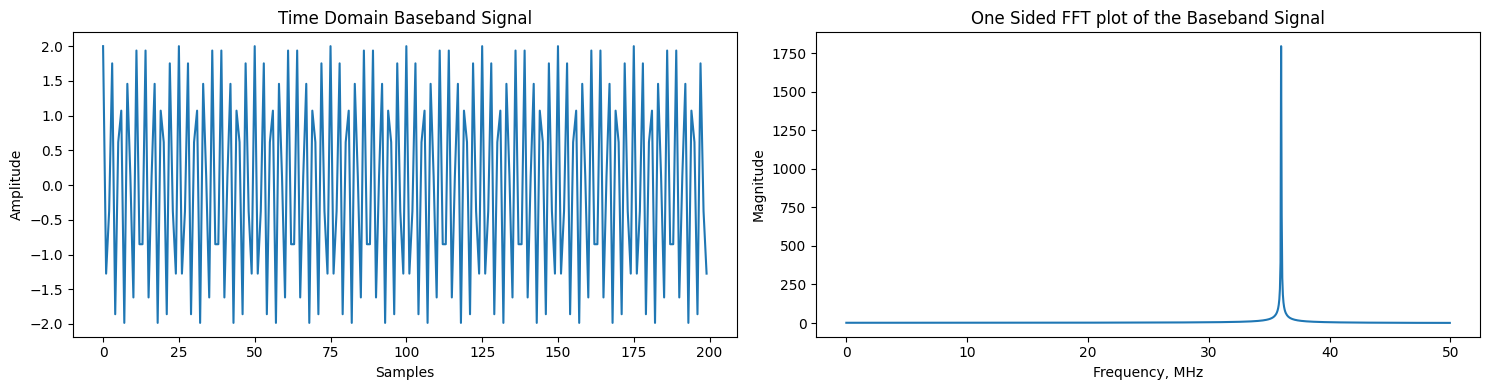

In [29]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(g[:200])
axs[0].set_title('Time Domain Baseband Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1e6, np.abs(g_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Baseband Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, MHz')
fig.tight_layout()

Similarly, a high frequency carrier signal can be defined. This signal has a much higher frequency that is used to modulate the information signal to the desired IF or RF band.

$$
c(t) = \cos(2 \pi f_{c} t)
$$

In [ ]:
fc = 1400e6 # Carrier Frequency

# Define Carrier Signal
c = np.cos(2*np.pi*fc*t)

In [ ]:
# Find FFT of Carrier
c_fft_result = np.fft.fft(c, N_fft)

We can now plot this carrier signal in the time and frequency domains. This signal has a higher frequency than the baseband signal and comprises of a single tone at $f_{c}$ in the frequency domain.

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(c[:100])
axs[0].set_title('Time Domain Carrier Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1e6, np.abs(c_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Carrier Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, MHz')
fig.tight_layout()

A modulated signal, $s(t)$, can now be obtained by multiplying our information signal, $g(t)$, by the carrier signal $c(t)$.

$$
s(t) = c(t) \times g(t)
$$

$$
s(t) = \cos(2 \pi f_{c} t) \times A\cos(2 \pi f_{b} t)
$$

Using trigonometry we can see that

$$
s(t) = \frac{A}{2} \cos(2 \pi (f_{c} - f_{b}) t) + \frac{A}{2} \cos(2 \pi (f_{c} + f_{b}) t).
$$

In Python, this modulated signal can be easily obtained by mutliplying the carrier signal $c(t)$ by the information signal, $g(t)$, as below.

In [ ]:
# Find Modulated Signal
s = g*c # Information signal, g(t), multiplied by carrier signal, c(t).

In [ ]:
# Find FFT of Modulated Signal
s_fft_result = np.fft.fft(s, N_fft)

We can plot the results of this modulation in the time and frequency domains.

Frequency components can be seen at $f_{c} - f_{b}$ and $f_{c} + f_{b}$. Therefore, the bandwidth occupied by the transmitted signal is $2 f_{b}$

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(s[:200])
axs[0].set_title('Time Domain Modulated Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1e6, np.abs(s_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Modulated Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, MHz')
fig.tight_layout()

## 4. Demodulation of the Baseband Signal <a class="anchor" id="demod"></a>

At the receiver, this modulated signal can be 'perfectly' demodulated using a local oscillator that matches the transmitter's carrier. The RF receiver design can be seen in Figure 3.

<figure>
<img src='https://github.com/tvy14/RFSoC-Book/blob/main/rfsoc_book/notebooks/notebook_E/images/amplitude_demodulation.svg?raw=1' height='60%' width='60%'/>
    <figcaption><b>Figure 3: Amplitude Demodulation of a Baseband Signal</b></figcaption>
</figure>

Demodulation can be seen as the reverse process of modulation. The modulated signal, $s(t)$, is multiplied by the carrier signal, $c(t)$, to produce a demodulated signal, $x(t)$. In the ideal scenario, the receiver carrier signal would be equivalent to $c_{t}$ in the transmitter.

$$
x(t) = c(t) \times s(t)
$$

This relationship correctly reconstructs the input signal. However, unwanted high frequency components remain at multiples of $f_{c}$.

$$x(t) = \frac{A}{2} \cos(2 \pi f_{b} t) + \frac{A}{4} \cos(2 \pi (2f_{c} - f_{b}) t) + \frac{A}{4} \cos(2 \pi (2f_{c} + f_{b}) t)$$

Within Python, this demodulation can be performed by multiplying the carrier signal, $c(t)$, by the received signal, $s(t)$.

In [ ]:
# Find Demodulated Signal
x = c*s # multiplication of carrier and received signals to perform demodulation

In [ ]:
# Find FFT of Demodulated Signal
x_fft_result = np.fft.fft(x, N_fft)

This demodulated signal can now be plotted in the time and frequency domains.

We can see that the original information signal at $f_{b}$ has been successfully recovered. However, unwanted high frequency components sitting at $2f_{c} - f_{b}$ and $2f_{c} + f_{b}$ are present.

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(x[:200])
axs[0].set_title('Time Domain Unfiltered Demodulated Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1e6, np.abs(x_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Unfiltered Demodulated Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, MHz')
fig.tight_layout()

As we can see from the above figure, the information signal has been successfully demodulated. However, unwanted high frequency components remain in the signal. These components can be removed using a lowpass filter, which we will design using the window method. This approach simply windows an ideal impulse response $h_d(n)$ by multiplying it by a window function $w(n)$, as follows.

$$
h(n) = w(n).h_d(n)
$$

In [ ]:
f_cutoff = 0.1 # Cutoff frequency as a fraction of the sampling rate
b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).

N = int(np.ceil((4 / b)))
if not N % 2: N += 1  # N is odd.
n = np.arange(N)

h = np.sinc(2 * f_cutoff * (n - (N - 1) / 2)) # Compute sinc filter.
w = np.blackman(N) # Compute Blackman window.
h = h * w # Multiply sinc filter by window.
h = h / np.sum(h) # Normalize to get unity gain.

The lowpass filter can be applied to the demodulated signal using convolution. Within Python, this operation can be performed simply by using `np.convolve()`.

In [ ]:
u = np.convolve(x, h)

The results of this low pass filter can be plotted, alongside the unfiltered signal.

The 'cost' of amplitude scaling demodulation, as the name suggests, is a 50% amplitude scaling. The scaling is particularly clear in the time domain plot. In the frequency domain, we can clearly see that the high frequency components are removed, leaving only the desired baseband signal.

With the removal of the high frequency components, the desired output can be obtained as,

$$
u(t) = \frac{A}{2} \cos(2 \pi f_{b} t).
$$

In [ ]:
u_fft_result = np.fft.fft(u, N_fft)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(u[:200])
axs[0].set_title('Time Domain Lowpass Filtered Demodulated Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1e6, np.abs(u_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Lowpass Filtered Demodulated Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, MHz')
fig.tight_layout()

## 5. Demodulation Phase Error <a class="anchor" id="phase_error"></a>

If the local oscillator is not exactly in phase with the received signal, the resulting phase error will cause an attenuation by a factor of $\cos(\theta)$, as shown below.

$$
\cos(2 \pi f_{b} t + \theta)
$$

In [ ]:
# Find phaseshifted local carrier
phaseshift = (np.pi/3) #60 degree phase shift
phase_carrier = np.cos(2*np.pi*fc*t + phaseshift) # Apply phaseshift to local receiver Carrier

# Find demodulated signal using new carrier - Modulated signal remains identical to before
phase_demodulation = phase_carrier*s # Demodulate Signal

# Apply Lowpass filter to demodulated signal
lp_phaseshift = np.convolve(phase_demodulation, h)

This concept can be shown by plotting the low pass filtered demodulated signal again, but incorporating a phase error into the local carrier signal.

By using a phase error of $\frac{\pi}{3}$ we observe an attenuation of $\cos(\frac{\pi}{3}) = 0.5.$

Therefore, in the time domain, we can observe an amplitude of $\frac{A}{4}$ compared to the transmitted signal.

In [ ]:
# Find PhaseShifted FFT Signal
phaseshift_fft_result = np.fft.fft(lp_phaseshift, N_fft)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(u[:200])
axs[0].plot(lp_phaseshift[:200])
axs[0].set_title('Time Domain Lowpass Filtered Demodulated Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')
axs[0].legend(('In phase Carrier', 'Phaseshifted Carrier'))

axs[1].plot(freqs[:int(N_fft/2)]/1e6, np.abs(u_fft_result[:int(N_fft/2)]))
axs[1].plot(freqs[:int(N_fft/2)]/1e6, np.abs(phaseshift_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Lowpass Filtered Demodulated Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, MHz')
axs[1].legend(('In phase Carrier', 'Phaseshifted Carrier'))
fig.tight_layout()

## 6. Conclusion <a class="anchor" id="conclusion"></a>

So far we have shown how amplitude modulation may be used to transmit a baseband signal at much higher frequencies whilst being able to recreate the original signal at the receiver. However there is an issue of spectral inefficiency - the baseband is $f_{b}$ Hz wide but the modulated signal is $2f_{b}$. Therefore, we require double the bandwidth to transmit the signal.

This problem can be addressed using QAM modulation schemes, addressed in the next notebook.

---

[⬅️ Previous Notebook](../notebook_D/03_pulse_shaping.ipynb) || [Next Notebook 🚀](02_qam_modulation.ipynb)

Copyright © 2023 Strathclyde Academic Media

---
---